In [1]:
# This implementation follows here: https://colab.research.google.com/github/andsteing/CLIP/blob/zeroshot/notebooks/zeroshot_evaluation.ipynb#scrollTo=Mo-MYo3Flgth

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm
import torch
from torchvision.datasets import CIFAR100
from IPython.display import display

import clip
from utils.init_model import model, preprocess, device, load_model, load

loading JIT archive /home/yuki/.cache/clip/ViT-B-32.pt


In [3]:
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [4]:
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True, train=False)
print(len(cifar100))

Files already downloaded and verified
10000


In [5]:
norm = preprocess.transforms[-1]
def denormalize(img):
  return img * torch.tensor(norm.std)[:, None, None] + torch.tensor(norm.mean)[:, None, None]
norm.mean, norm.std

((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

(torch.Size([224, 224, 3]), tensor(0.1765), tensor(1.))

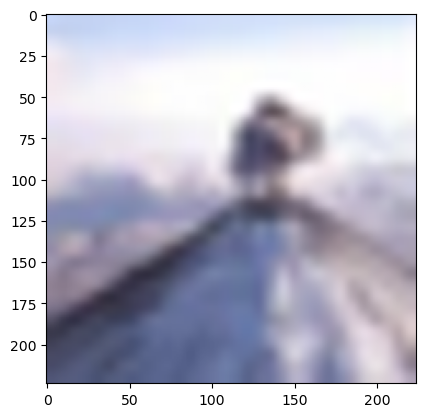

In [6]:
img, label = next(iter(cifar100))
img = denormalize(img).permute(1, 2, 0)
plt.imshow(img)
img.shape, img.min(), img.max()

In [7]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(cifar100,
                                          batch_size=batch_size,
                                          shuffle=False)

In [8]:
x = next(iter(data_loader))
x[0].shape, x[1].shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [9]:
## load model
# checkpoint_path = 'model_checkpoints/ViT-B_32_9101191011_batch64_aug250_lower_bound_of_scale0.35_use_negative_lr2e-05-0.1_image_file_dir.pt'
# checkpoint_path = 'model_checkpoints/cross_validation_5_0_ViT-B_32_9101191011_batch64_aug250_lower_bound_of_scale0.35_max_attribute_num_3_random_prompts_num_70000_use_negative_lr2e-05-0.1.pt'

checkpoint_path = 'model_checkpoints/cv_5_0_ViT-B_32_bce_loss_9101191011_batch64_aug250_lower_bound_of_scale0.35_max_attribute_num_3_random_prompts_num_70000_use_negative_lr2e-05-0.1_image_file_dir.pt'
# checkpoint_path = None
model = load_model(model, checkpoint_path)
# model.initialize_parameters()

In [18]:
checkpoint_path = 'model_checkpoints/cross_validation_5_0_ViT-B_32_9101191011_batch64_aug250_lower_bound_of_scale0.35_max_attribute_num_3_random_prompts_num_70000_use_negative_lr2e-05-0.1.pt'
fclip_model = load_model(model, checkpoint_path)

## Show some examples

In [10]:
image_input, image_labels = next(iter(data_loader))
image_input = image_input.cuda()
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()
with torch.no_grad():
  image_features = model.encode_image(image_input).float()
  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features = model.encode_text(text_tokens).float()
  text_features /= text_features.norm(dim=-1, keepdim=True)
print(image_features.shape, text_features.shape)
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

torch.Size([128, 512]) torch.Size([100, 512])


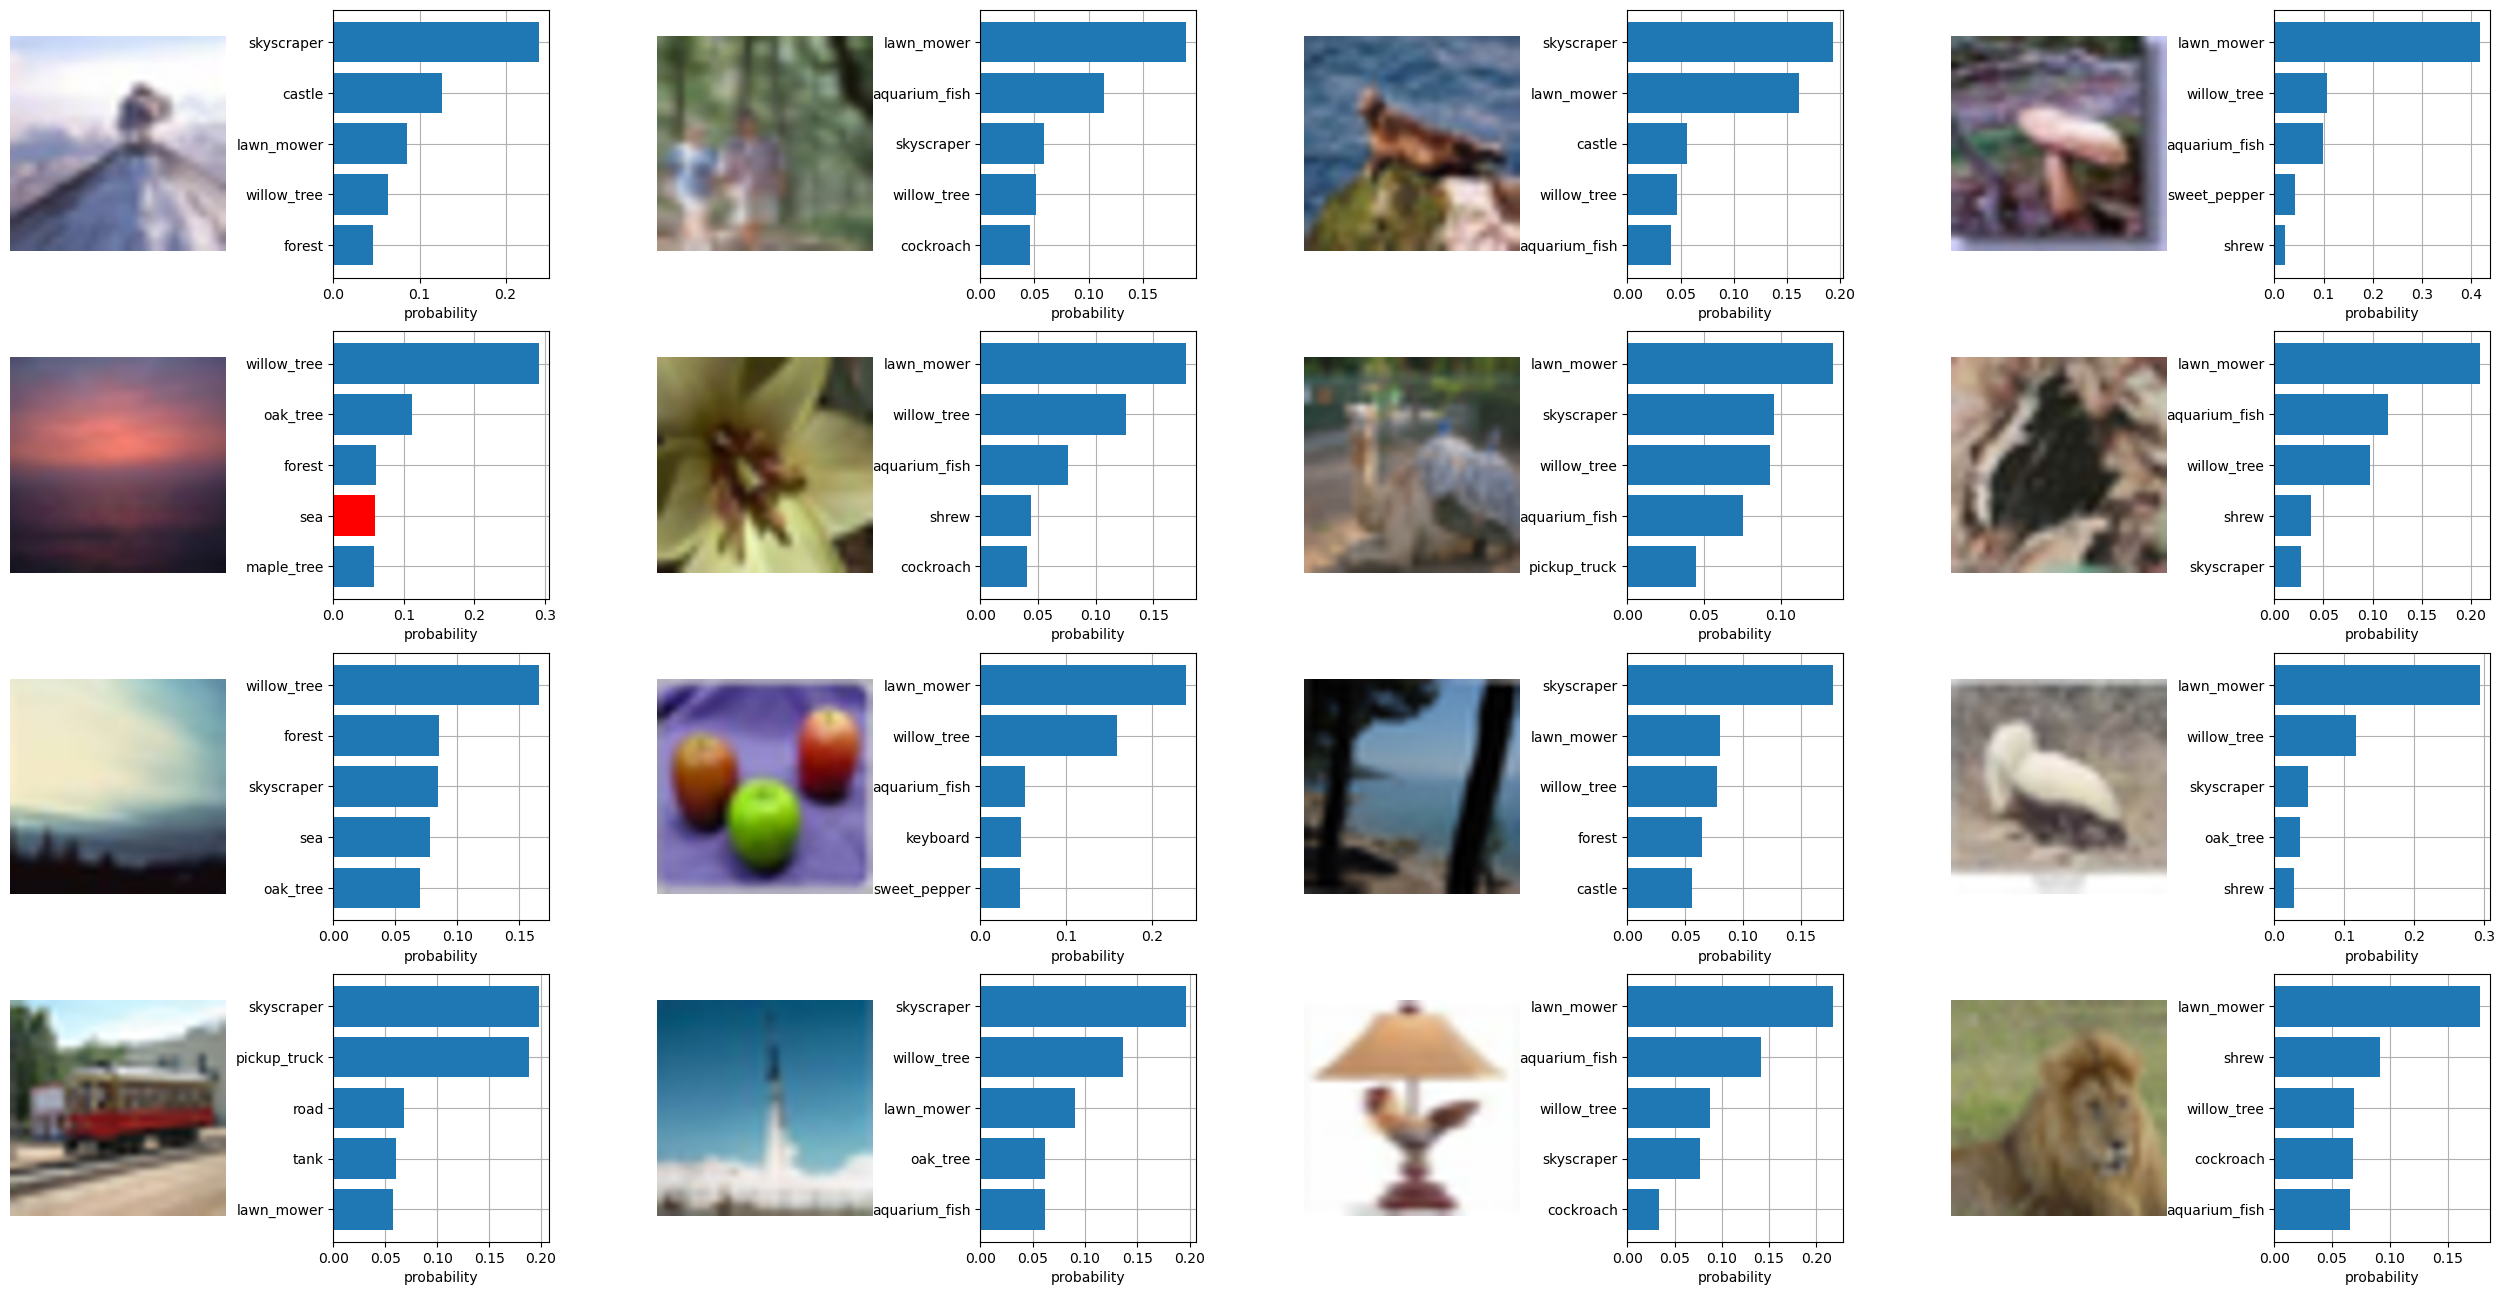

In [11]:
rows, cols = 4, 4
plt.figure(figsize=(cols*8, rows*4))

for i, image in enumerate(image_input[:rows*cols]):
    plt.subplot(rows, cols * 2, 2 * i + 1)
    plt.imshow(denormalize(image.cpu()).permute(1, 2, 0))
    plt.axis("off")

    plt.subplot(rows, cols * 2, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    if image_labels[i] in top_labels[i]:
      j = list(top_labels[i]).index(image_labels[i])
      plt.barh([j], [top_probs[i][j]], color='r')
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
# plt.savefig('outputs/cifar100_CLIPvision_FontCLIPtext.png')
plt.savefig('outputs/cifar100_FontCLIP.png')
plt.show()

# Quantitative Evaluation with CIFAR100

In [12]:
templates80 = [
    'a bad photo of a {}.',
    'a photo of many {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.',
    'graffiti of a {}.',
    'a bad photo of the {}.',
    'a cropped photo of the {}.',
    'a tattoo of a {}.',
    'the embroidered {}.',
    'a photo of a hard to see {}.',
    'a bright photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a drawing of a {}.',
    'a photo of my {}.',
    'the plastic {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a black and white photo of the {}.',
    'a painting of the {}.',
    'a painting of a {}.',
    'a pixelated photo of the {}.',
    'a sculpture of the {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a plastic {}.',
    'a photo of the dirty {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a rendering of the {}.',
    'a {} in a video game.',
    'a photo of one {}.',
    'a doodle of a {}.',
    'a close-up photo of the {}.',
    'a photo of a {}.',
    'the origami {}.',
    'the {} in a video game.',
    'a sketch of a {}.',
    'a doodle of the {}.',
    'a origami {}.',
    'a low resolution photo of a {}.',
    'the toy {}.',
    'a rendition of the {}.',
    'a photo of the clean {}.',
    'a photo of a large {}.',
    'a rendition of a {}.',
    'a photo of a nice {}.',
    'a photo of a weird {}.',
    'a blurry photo of a {}.',
    'a cartoon {}.',
    'art of a {}.',
    'a sketch of the {}.',
    'a embroidered {}.',
    'a pixelated photo of a {}.',
    'itap of the {}.',
    'a jpeg corrupted photo of the {}.',
    'a good photo of a {}.',
    'a plushie {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'the cartoon {}.',
    'art of the {}.',
    'a drawing of the {}.',
    'a photo of the large {}.',
    'a black and white photo of a {}.',
    'the plushie {}.',
    'a dark photo of a {}.',
    'itap of a {}.',
    'graffiti of the {}.',
    'a toy {}.',
    'itap of my {}.',
    'a photo of a cool {}.',
    'a photo of a small {}.',
    'a tattoo of the {}.',
]
templates7 = '''itap of a {}.
a bad photo of the {}.
a origami {}.
a photo of the large {}.
a {} in a video game.
art of the {}.
a photo of the small {}.'''.split('\n')

In [14]:
def zeroshot_classifier(classnames, templates):
  with torch.no_grad():
    zeroshot_weights = []
    for classname in tqdm.tqdm(classnames):
      texts = [template.format(classname) for template in templates] #format with class
      texts = clip.tokenize(texts).cuda() #tokenize
      class_embeddings = model.encode_text(texts) #embed with text encoder
      class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
      class_embedding = class_embeddings.mean(dim=0)
      class_embedding /= class_embedding.norm()
      zeroshot_weights.append(class_embedding)
    zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
  return zeroshot_weights


zeroshot_weights = zeroshot_classifier(cifar100.classes, templates7)
zeroshot_weights_ = zeroshot_classifier(cifar100.classes, templates80)
print(zeroshot_weights.shape, zeroshot_weights_.shape)

100%|██████████| 100/100 [00:02<00:00, 45.07it/s]

torch.Size([512, 100]) torch.Size([512, 100])


In [15]:
def accuracy(output, target, topk=(1,)):
  pred = output.topk(max(topk), 1, True, True)[1].t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]

with torch.no_grad():
  top1, top5, top1_, top5_, n = 0., 0., 0., 0., 0.
  for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
    images = images.cuda()
    target = target.cuda()

    # predict
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # measure accuracy
    logits = 100. * image_features @ zeroshot_weights
    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
    top1 += acc1
    top5 += acc5
    logits = 100. * image_features @ zeroshot_weights_
    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
    top1_ += acc1
    top5_ += acc5

    n += images.size(0)

top1 = (top1 / n) * 100
top5 = (top5 / n) * 100 
top1_ = (top1_ / n) * 100
top5_ = (top5_ / n) * 100 

print()
print(f"Top-1 accuracy: {top1:.2f} {top1_:.2f}")
print(f"Top-5 accuracy: {top5:.2f} {top5_:.2f}")


# batch_size=128

# RN50
# Top-1 accuracy: 40.93 41.04 -- expected 41.6
# Top-5 accuracy: 73.14 72.37

# B/32
# Top-1 accuracy: 64.58 64.21 -- expected 65.1
# Top-5 accuracy: 88.61 88.08


# verified that batch_size=32 reproduce the same results:

# B/32
# Top-1 accuracy: 64.58 64.21 -- expected 65.1
# Top-5 accuracy: 88.61 88.08


# => missing ~0.5% with templates7 (~0.6% with templates80)

100%|██████████| 79/79 [00:08<00:00,  9.21it/s]


Top-1 accuracy: 2.20 2.21
Top-5 accuracy: 11.61 11.61


# Qualitative Evaluation of the CLIP Vision Space with TSNE

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms.functional import to_pil_image

In [17]:
def show_map(vectors, classes, figsize=(15, 15), colors = ["r", "g", "b", "c", "m", "y", "k", "pink", "purple", 'gray'], save_file_path=None, show_legend=True):
  each_class_image_num = len(vectors) // len(classes)
  fig, ax = plt.subplots(figsize=figsize)

  for i in range(len(classes)):
    for j in range(each_class_image_num):
        tmp_index = i * each_class_image_num + j
        if j == 0:
          ax.scatter(vectors[tmp_index, 0], vectors[tmp_index, 1], marker='o', color=colors[i], alpha=0.5, label=classes[i], s = 400)
        else:
          ax.scatter(vectors[tmp_index, 0], vectors[tmp_index, 1], marker='o', color=colors[i], alpha=0.5, s = 400)
          

  plt.axis('off')
  if show_legend:
    # set legend
    plt.legend()
  if save_file_path is not None:
    plt.savefig(save_file_path)
  plt.show()

In [18]:
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True, train=False)
classes_10 = [cifar100.classes[i*10] for i in range(10)]
print(len(cifar100))
print(classes_10)

Files already downloaded and verified
10000
['apple', 'bowl', 'chair', 'dolphin', 'lamp', 'mouse', 'plain', 'rose', 'squirrel', 'train']


In [19]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(cifar100, batch_size=batch_size, shuffle=False)
image_input = [[] for _ in range(10)]
for tmp_image_inputs, tmp_image_labels in iter(data_loader):
  for tmp_image_input, tmp_image_label in zip(tmp_image_inputs, tmp_image_labels):
    for i, classname in enumerate(classes_10):
      if tmp_image_label == i * 10:
        if len(image_input[i]) < 10:
          image_input[i].append(tmp_image_input)
        break

In [20]:
image_input_tensor = torch.cat([torch.stack(image_input[i]) for i in range(10)], dim=0)
print(image_input_tensor.shape)

torch.Size([100, 3, 224, 224])


In [21]:
image_input_tensor = image_input_tensor.cuda()
with torch.no_grad():
  image_features = model.encode_image(image_input_tensor).float()
  image_features /= image_features.norm(dim=-1, keepdim=True)
  image_features = image_features[:100]
print(image_features.shape)

torch.Size([100, 512])


In [22]:
# for i in range(10):
#   class_name = classes_10[i]
#   for j in range(10):
#     image = to_pil_image(denormalize(image_input_tensor[i*10+j].cpu()))
#     image.save(f'outputs/cifar100/{class_name}_{j}.png')

In [23]:
tsne = TSNE(n_components=2, random_state=0, perplexity=30)
tsned_image_features = tsne.fit_transform(image_features.cpu().detach().numpy())

/home/yuki/anaconda3/envs/dgfont-env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/yuki/anaconda3/envs/dgfont-env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


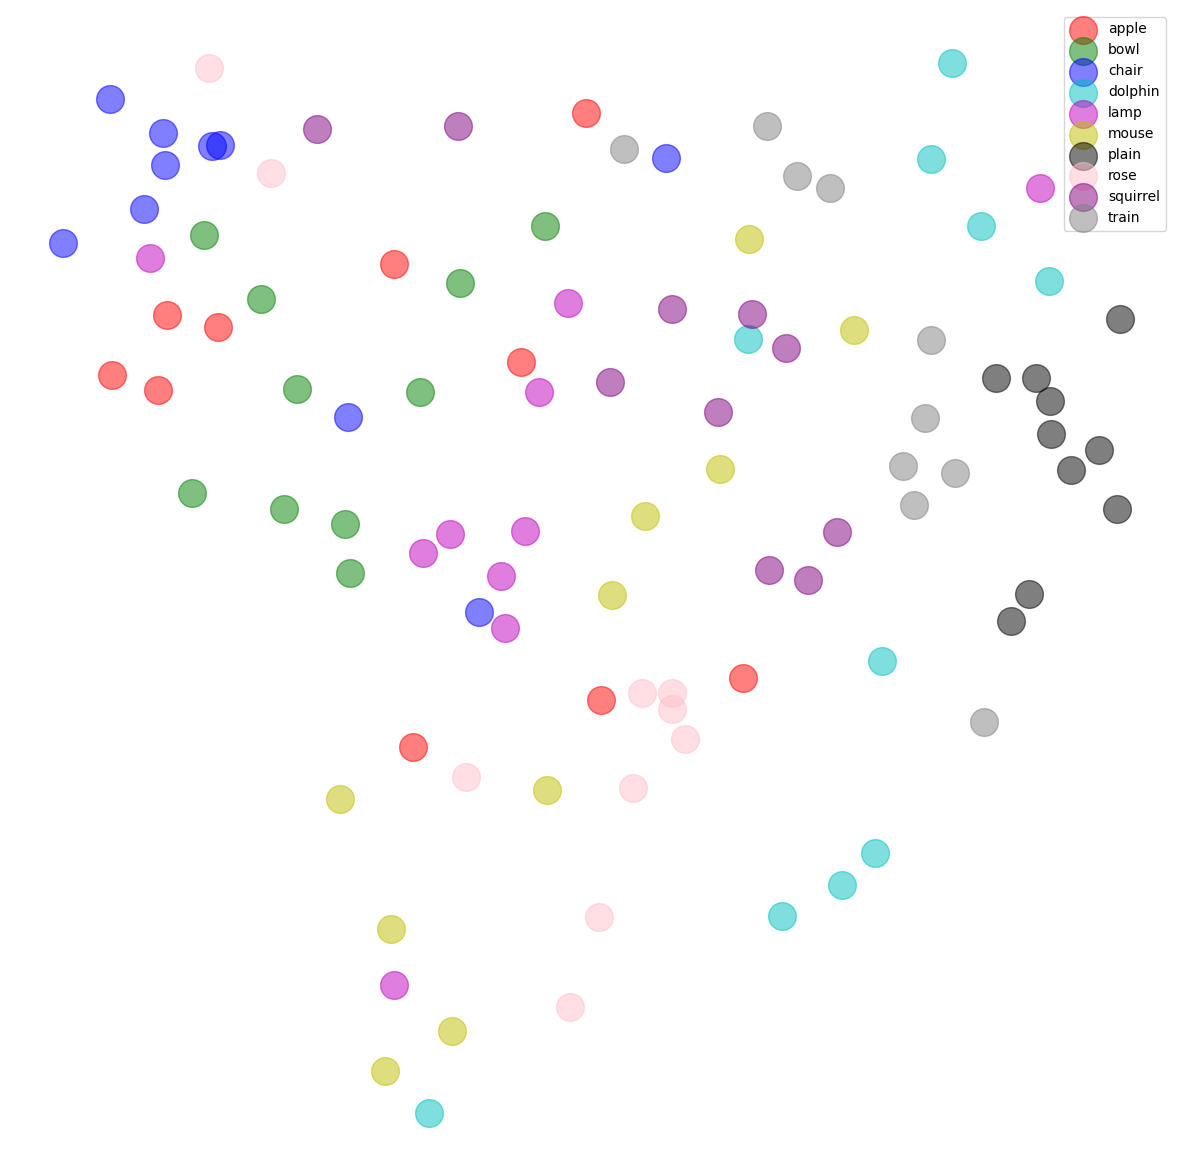

In [24]:
show_map(tsned_image_features, classes_10, save_file_path='outputs/cifar100_FontVanillaVisionCLIP_tsne.png')

# Qualitative Evaluation of the CLIP Text Space with TSNE

In [34]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms.functional import to_pil_image

In [35]:
templates10 = [
    'a photo of a {}.',
    'a bad photo of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a bad photo of the {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
]

In [36]:
def show_map(vectors, classes, figsize=(15, 15), colors = ["r", "g", "b", "c", "m", "y", "k", "pink", "purple", 'gray'], save_file_path=None, show_legend=True):
  each_class_image_num = len(vectors) // len(classes)
  fig, ax = plt.subplots(figsize=figsize)

  for i in range(len(classes)):
    for j in range(each_class_image_num):
        tmp_index = i * each_class_image_num + j
        # ax.annotate(templates10[j], (vectors[tmp_index, 0], vectors[tmp_index, 1]), fontsize=35, color=colors[i])
        if j == 0:
          ax.scatter(vectors[tmp_index, 0], vectors[tmp_index, 1], marker='o', color=colors[i], alpha=0.5, label=classes[i], s = 400)
        else:
          ax.scatter(vectors[tmp_index, 0], vectors[tmp_index, 1], marker='o', color=colors[i], alpha=0.5, s = 400)

          

  plt.axis('off')
  if show_legend:
    # set legend
    plt.legend()
  if save_file_path is not None:
    plt.savefig(save_file_path)
  plt.show()

In [37]:
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True, train=False)
classes_10 = [cifar100.classes[i*10] for i in range(10)]
print(len(cifar100))
print(classes_10)

Files already downloaded and verified
10000
['apple', 'bowl', 'chair', 'dolphin', 'lamp', 'mouse', 'plain', 'rose', 'squirrel', 'train']


In [38]:
def text_features_for_visualize(classnames, templates):
  with torch.no_grad():
    zeroshot_weights = None
    for classname in tqdm.tqdm(classnames):
      texts = [template.format(classname) for template in templates] #format with class
      texts = clip.tokenize(texts).cuda() #tokenize
      class_embeddings = model.encode_text(texts) #embed with text encoder
      class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
      if zeroshot_weights is None:
        zeroshot_weights = class_embeddings
      else:
        zeroshot_weights = torch.cat([zeroshot_weights, class_embeddings], dim=0)
  return zeroshot_weights

text_features = text_features_for_visualize(classes_10, templates10)
print(text_features.shape)

100%|██████████| 10/10 [00:00<00:00, 218.70it/s]

torch.Size([100, 512])


In [39]:
tsne = TSNE(n_components=2, random_state=0, perplexity=30)
tsned_text_features = tsne.fit_transform(text_features.cpu().detach().numpy())

/home/yuki/anaconda3/envs/dgfont-env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/yuki/anaconda3/envs/dgfont-env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


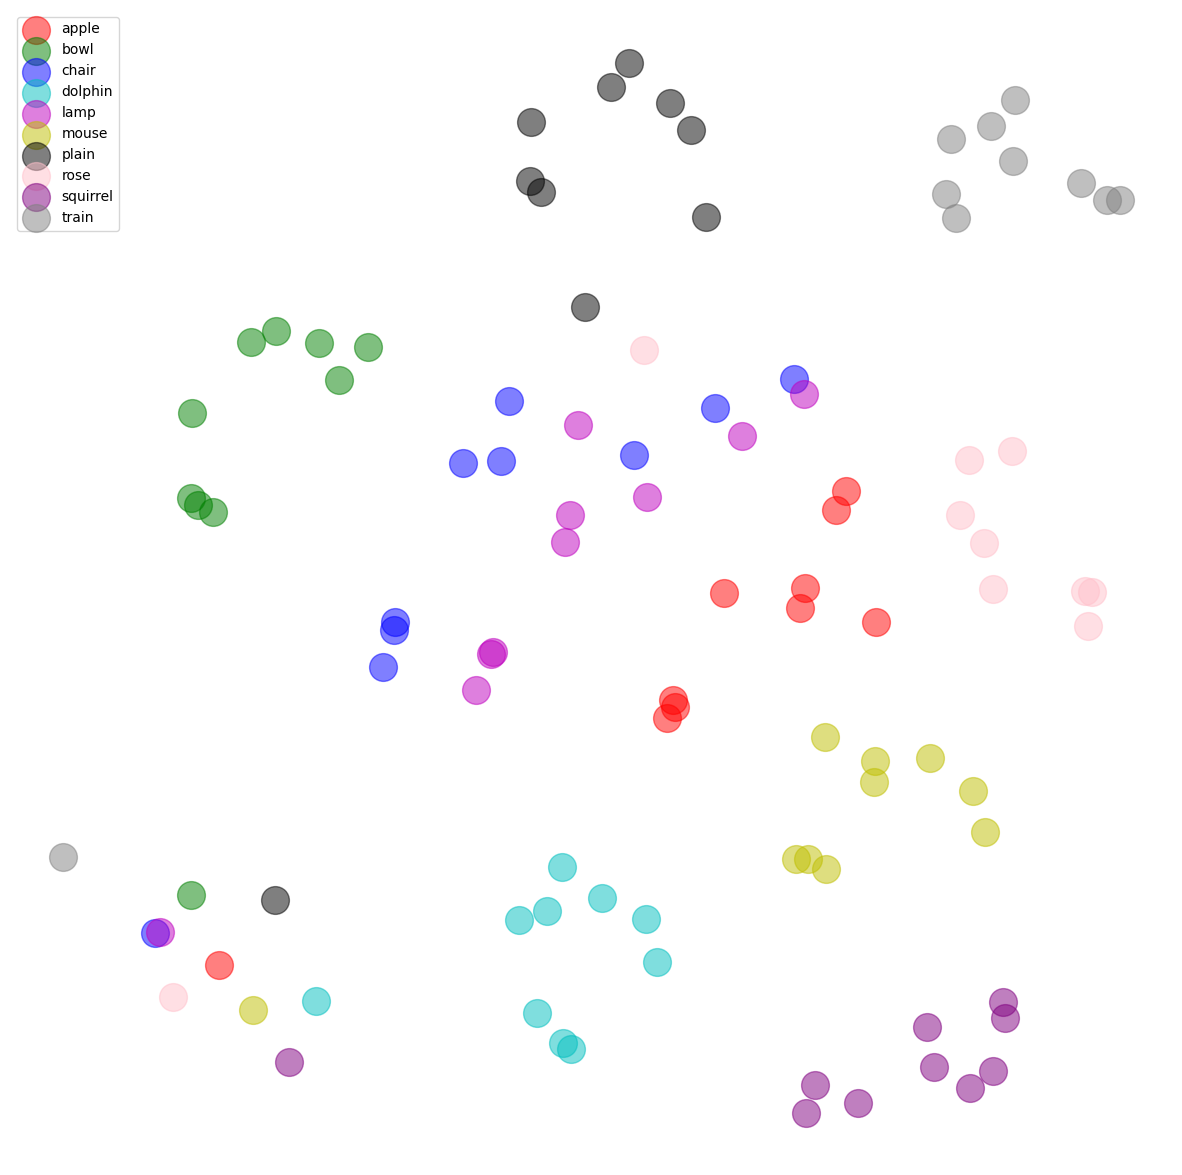

In [42]:
show_map(tsned_text_features, classes_10, save_file_path='outputs/cifar100_FontVanillaTextCLIP_text_tsne.png')